In [1]:
import os
import sys
import json
import argparse
from time import time
from functools import partial

import numpy as np
import pandas as pd

from tqdm import tqdm

from sklearn.preprocessing import normalize
from sklearn.random_projection import GaussianRandomProjection
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors

from rsq.samplers import *
from rsq.samplers import _Sampler
from rsq.helpers import set_seeds

from rsq import SVCEnsemble, AgglomerativeEnsemble, AgglomerativeClassifier
from rsq.agglomerative_helpers import get_tree_distances, get_decision_paths

from joblib import Parallel, delayed

def stratified_sample(y, p=0.67, replace=False):
    unique_y, counts = np.unique(y, return_counts=True)
    n_per_class = np.array([int(np.math.floor(p*c)) for c in counts])
    n_per_class = np.array([max([npc, 1]) for npc in n_per_class])
    
    inds = [np.random.choice(np.where(y == unique_y[i])[0], size=npc, replace=replace) for i, npc in enumerate(n_per_class)]
    
    return np.concatenate(inds)

In [27]:
import numpy as np

from sklearn.cluster import AgglomerativeClustering 
from sklearn.neighbors import NearestNeighbors
from sklearn.random_projection import GaussianRandomProjection
from scipy.special import softmax

from joblib import delayed, Parallel
from numba import jit

from rsq.agglomerative_helpers import get_tree_distances, get_decision_paths

import itertools

def stratified_sample(y, p=0.67, replace=False):
    unique_y, counts = np.unique(y, return_counts=True)
    n_per_class = np.array([int(np.math.floor(p*c)) for c in counts])
    n_per_class = np.array([max([npc, 1]) for npc in n_per_class])
    
    inds = [np.random.choice(np.where(y == unique_y[i])[0], size=npc, replace=replace) for i, npc in enumerate(n_per_class)]
    
    return np.concatenate(inds)


def gem(x, p=1):
    """ generalized mean pooling -- interpolation between mean and max """
    nobs, ndim = x.shape
    
    y = np.zeros(ndim)
    for r in range(nobs):
        for c in range(ndim):
            y[c] += x[r,c] ** p
    
    y /= nobs
    
    for c in range(ndim):
        y[c] = y[c] ** (1 / p)
    
    return y



class AgglomerativeClassifier:
    def __init__(self, n_clusters=2, affinity='cosine', linkage='average',
                n_neighbors=1,
                 max_tree_distance=None,
                 soft_max_multiplier=10,
                 gem_p=1,
                classes=None):
        
        self.n_clusters = n_clusters
        self.affinity = affinity
        self.linkage = linkage
        
        self.n_neighbors = n_neighbors
                
        self.classes_ = classes
        
        self.max_tree_distance=max_tree_distance
        self.soft_max_multiplier=soft_max_multiplier
        
        self.gem_p = gem_p
        
        
    def fit(self, X, y):
        self.n, d = X.shape

        self.labeled_inds = np.where(y != -1)[0]
                
        if self.classes_ is None:
            self.classes_ = np.unique(y[self.labeled_inds])
            
        if -1 in self.classes_:
            self.classes_ = self.classes_[1:]
                        
        self.model = AgglomerativeClustering(n_clusters=self.n_clusters, 
            affinity=self.affinity, 
            linkage=self.linkage, 
            compute_full_tree=True
            )
        print("agg")
        self.model.fit(X)
                    
        self.nn = NearestNeighbors(n_neighbors=self.n_neighbors, metric=self.affinity)
        print("nn")
        self.nn.fit(X)
        
        labeled_inds_by_class = [np.where(y[self.labeled_inds] == c)[0] for c in self.classes_]
        decision_paths, counts = get_decision_paths(self.n, self.model.children_)
        
        self._get_tree_distances(decision_paths, counts)        
        self._get_similarities_to_classes(labeled_inds_by_class)
        
                                    
    def _get_tree_distances(self, decision_paths, counts):
        self.tree_distances = get_tree_distances(self.n, decision_paths, self.labeled_inds, counts, self.max_tree_distance)
        self.tree_distances = np.log(self.tree_distances) + 1
        self.tree_distances = 1 / self.tree_distances
        self.tree_distances = softmax(self.soft_max_multiplier * self.tree_distances, axis=0)
        
        
    def _get_similarities_to_classes(self, labeled_inds_by_class):
        self.similarities_to_classes = np.zeros((self.n, len(self.classes_)))
        
        for i, ibc in enumerate(labeled_inds_by_class):
            self.similarities_to_classes[:, i] = gem(self.tree_distances[:, ibc].T, p=self.gem_p)
                                              
        self.similarities_to_classes = softmax(self.similarities_to_classes, axis=1)
        
        
    def predict_proba(self, X):
        _, neighbor_inds = self.nn.kneighbors(X)
        scores = np.mean(self.similarities_to_classes[neighbor_inds], axis=1)
        return softmax(scores, axis=1)
    
    
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), axis=1)]


In [30]:
from sklearn.datasets import make_moons
from sklearn.cluster import AgglomerativeClustering

n=10
X, y = make_moons(n, noise=0.1)

n_labeled=1
inds = np.random.choice(len(y), n_labeled, replace=False).astype(np.int32)

y_ = -1 * np.ones(n)
y_[inds] = y[inds]

clu=AgglomerativeClassifier(affinity='euclidean', linkage='single')
clu.fit(X, y_)

decision_paths, counts = get_decision_paths(n, clu.model.children_)
ha=get_tree_distances(n, decision_paths, inds, counts, max_tree_distance=2)

agg
nn


In [31]:
def few_shot_sample(y, n_samples_per_class=1):
    unique_y = np.unique(y)    
    inds = [np.random.choice(np.where(y == c)[0], size=n_samples_per_class, replace=False) for c in unique_y]
    
    return np.concatenate(inds)

In [32]:
# --
# Helpers

def subset(X, y, n):
    if isinstance(X, list):
        sel = np.random.choice(X[0].shape[0], n, replace=False)
        return [x[sel] for x in X], y[sel]
    
    sel = np.random.choice(X.shape[0], n, replace=False)
    
    return X[sel], y[sel]

def shuffle(X, y):
    """ shuffle X and y """
    
    if isinstance(X, list):
        sel = np.random.permutation(X[0].shape[0])
        return [x[sel] for x in X], y[sel]
    
    sel = np.random.permutation(X.shape[0])
    return X[sel], y[sel]

def adjust_prevalance(X, y, n_pos):
    """ adjust the prevalance of the positive class """
    
    pos_idx = np.where(y == 1)[0]
    neg_idx = np.where(y == 0)[0]
    sel = np.hstack([
        np.random.choice(pos_idx, n_pos, replace=False),
        neg_idx,
    ])
    
    if isinstance(X, list):
        return [x[sel] for x in X], y[sel]
    
    sel = np.random.permutation(sel)
    return X[sel], y[sel]


def process_data(X, y, n_pos_labels, n_all):
    X, y  = shuffle(X, y)

    X = [normalize(x, axis=1, norm='l2') for x in X]

    X, y = subset(X, y, n=n_all)

    target = np.random.choice(np.unique(y)) # !! Uniform sample class, not according to prevalance
    y      = (y == target).astype(np.int)

    X, y = adjust_prevalance(X, y, n_pos_labels)
    
    return X, y
        
def experiment(process_args, experiment_args):
    X, y = process_data(*process_args)
        
    return run_exp(X, y, *experiment_args)

In [33]:
# --
# Experiment parameters & initial data loading

np.random.seed(1)


data_files = ['../output/feats/crow_resnet50/birdsnap/']
models = [s.split('/')[-3] for s in data_files]


X = [np.load(os.path.join(f, 'X.npy')).astype(np.float64) for f in data_files][0]
X = X.copy() / np.sqrt((X.copy() ** 2).sum(axis=-1, keepdims=True))
y_str = np.load(os.path.join(data_files[0], 'y.npy'))
classes_str, class_counts= np.unique(y_str, return_counts=True)
y=np.zeros(len(y_str))
for i, str_ in enumerate(classes_str):
    y[np.where(y_str == str_)[0]] = i

y = y.astype(int)
classes=np.unique(y)

print(X.shape, len(y), len(classes), np.min(class_counts), np.median(class_counts), np.max(class_counts))

(32682, 2048) 32682 500 29 68.0 83


In [54]:
from sklearn.svm import LinearSVC

def ssl_exp(X, y, n_samples_per_class=1, acorn=None):    
    inds_sup = few_shot_sample(y, n_samples_per_class)
    inds_unsup = np.array([i for i in range(len(y)) if i not in inds_sup]).astype(int)
    X=X.copy()

    y_ = -1 * np.ones(n)
    y_[inds_sup] = y[inds_sup]
    
    #- 2 = Supervised, Semisupervised
    accs = np.zeros(2)
    times = np.zeros(2)
        
    
    print("begin fit2")
    #- Semi-Supervised
    svc_semisup = AgglomerativeClassifier(linkage='average', max_tree_distance=400)
    time_ = time()
    svc_semisup.fit(X, y_)
    
    accs[1] = (svc_semisup.predict(X[inds_unsup]) == y[inds_unsup]).mean()
    times[1] = time() - time_
    
    print("finish fit+predict 2 in", times[1], "seconds")
    time_ = time()
    
    
    print("begin fit1")
    #- Supervised
    svc_sup = LinearSVC(C=1)
    time_ = time()
    svc_sup.fit(X[inds_sup], y[inds_sup])
    accs[0] = (svc_sup.predict(X[inds_unsup]) == y[inds_unsup]).mean()
    times[0] = time() - time_
    print("finish fit+predict 1 in", times[0], "seconds")
        
    return accs, times

In [72]:
np.random.seed(1)

n_samples_per_class=[1]
n_cores=40
# n_mc=int(n_cores / len(prop_labeled))
n_mc=10

experiment_tuples = []

for i, p in enumerate(n_samples_per_class):
    for _ in range(n_mc):
        all_inds = stratified_sample(y, p=0.5, replace=False)
        n=len(all_inds)
        
        experiment_tuples.append((X[all_inds], y[all_inds], p))
    

condensed_func = lambda x: ssl_exp(*x)
start_time = time()
print(len(experiment_tuples))
# try:
#     accuracies_and_times = Parallel(n_jobs=n_cores)(delayed(condensed_func)(tupl) for tupl in experiment_tuples)
#     print("finished in %1.1f"%(time() - start_time))
# except:
#     print("error after %1.1f"%(time() - start_time))
#     assert 0 == 1

10


In [61]:
accuracies = np.zeros((len(n_samples_per_class), 2, n_mc))
times = np.zeros((len(n_samples_per_class), 2, n_mc))

for i in range(len(n_samples_per_class)):
    for j in range(n_mc):
        temp = accuracies_and_times[i*len(n_samples_per_class) + j]
        accuracies[i,:, j] = temp[0]
        times[i,:, j] = temp[1]

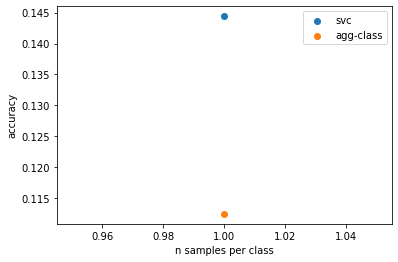

In [62]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1)

algos = ['svc', 'agg-class']
for i, algo in enumerate(algos):
    ax.scatter(n_samples_per_class, np.mean(accuracies, axis=-1)[:, i], label=algo)
    
ax.set_ylabel("accuracy")
ax.set_xlabel("n samples per class")
ax.legend()

In [73]:
X_, y_, n_ = experiment_tuples[0]

In [24]:
X_.shape

(16218, 2048)

In [25]:
%%time
nn = NearestNeighbors(metric='cosine')
nn.fit(X_)

CPU times: user 23.1 ms, sys: 0 ns, total: 23.1 ms
Wall time: 22.2 ms


NearestNeighbors(metric='cosine')

In [26]:
%%time
clu=AgglomerativeClustering(affinity='cosine', linkage='single')
clu.fit(X_)

CPU times: user 3min 32s, sys: 106 ms, total: 3min 32s
Wall time: 3min 32s


AgglomerativeClustering(affinity='cosine', linkage='single')

In [27]:
%%time
decision_paths, counts = get_decision_paths(X_.shape[0], clu.children_)

CPU times: user 1.5 s, sys: 252 ms, total: 1.75 s
Wall time: 1.75 s


(array([1205., 1236., 1231., 1257., 1421., 1333., 1422., 1664., 2323.,
        3126.]),
 array([2.00000e+00, 1.12260e+03, 2.24320e+03, 3.36380e+03, 4.48440e+03,
        5.60500e+03, 6.72560e+03, 7.84620e+03, 8.96680e+03, 1.00874e+04,
        1.12080e+04]),
 <BarContainer object of 10 artists>)

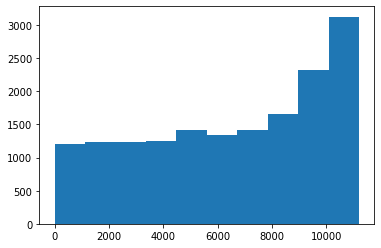

In [28]:
import matplotlib.pyplot as plt
plt.hist(counts)

In [29]:
%%time
tree_distances = get_tree_distances(X_.shape[0], decision_paths, np.arange(500), counts, max_tree_distance=200)

CPU times: user 3min 28s, sys: 18.3 ms, total: 3min 28s
Wall time: 3min 28s


In [ ]:
%%time
inds = few_shot_sample(y_)
y__ = -1 * np.ones(len(y_))
y__[inds] = y_[inds]
clf = AgglomerativeClassifier(linkage='single', max_tree_distance=200)
clf.fit(X_, y__)

In [14]:
%%time
inds = few_shot_sample(y_)
y__ = -1 * np.ones(len(y_))
y__[inds] = y_[inds]
clf = AgglomerativeClassifier(linkage='single', max_tree_distance=400)
clf.fit(X_, y__)

NameError: name 'X_' is not defined

In [21]:
X_.shape

(6338, 2048)

In [10]:
np.random.seed(1)
inds = stratified_sample(y, p=0.2)
labeled_inds = stratified_sample(y[inds], p=0.1)
y_ = -1 * np.ones(len(inds))
y_[labeled_inds] = y[inds[labeled_inds]]

In [90]:
linear_svc = LinearSVC(C=1)
time_ = time()
linear_svc.fit(X[inds[labeled_inds]], y_[labeled_inds])

print("time to train linear SVC:", time() - time_, (linear_svc.predict(X[inds]) == y[inds]).mean())

IndexError: index 2 is out of bounds for axis 0 with size 1

In [29]:
agg = AgglomerativeEnsemble(n_estimators=1, p_inbag=1, 
                            projector=None, projection_kwargs={'n_components': 64}, n_neighbors=1, n_jobs=1)
time_ = time()
agg.fit(X[inds[labeled_inds]], y_[labeled_inds])

print("time to train linear SVC:", time() - time_, (agg.predict(X[inds]) == y[inds]).mean())

time to train linear SVC: 2.8693134784698486 0.20605869359419376


In [38]:
from sklearn.neighbors import KNeighborsClassifier

nn = KNeighborsClassifier(n_neighbors=1, metric='cosine')

time_=time()
nn.fit(X[inds], y[inds])
print("time to train linear SVC:", time() - time_, (nn.predict(X[inds]) == y[inds]).mean())

time to train linear SVC: 0.025906801223754883 1.0


In [66]:
labeled_inds = few_shot_sample(y_)

In [76]:
agg= AgglomerativeEnsemble(n_estimators=100, p_inbag=1, projector='gaussian', 
                           projection_kwargs={'n_components': 256}, n_neighbors=1, 
                           n_jobs=90)

time_ = time()
agg.fit(X_[labeled_inds], y_[labeled_inds])

print("time to train linear SVC:", time() - time_, (agg.predict(X_) == y_).mean())

time to train linear SVC: 27.189078092575073 0.12782093969663336


In [77]:
agg= AgglomerativeEnsemble(n_estimators=100, p_inbag=1, projector='gaussian', 
                           projection_kwargs={'n_components': 256}, n_neighbors=1, 
                           n_jobs=10)

time_ = time()
agg.fit(X_[labeled_inds], y_[labeled_inds])

print("time to train linear SVC:", time() - time_, (agg.predict(X_) == y_).mean())

time to train linear SVC: 21.436809301376343 0.12782093969663336


In [96]:
agg_sup= AgglomerativeEnsemble(n_estimators=90, p_inbag=1, projector='gaussian', 
                           projection_kwargs={'n_components': 16}, n_neighbors=1, 
                           n_jobs=90)

time_ = time()
agg_sup.fit(X_[labeled_inds], y_[labeled_inds])

print("time to train linear SVC:", time() - time_, (agg_sup.predict(X_) == y_).mean())

time to train linear SVC: 27.90682029724121 0.12782093969663336


In [92]:
agg= AgglomerativeEnsemble(n_estimators=90, p_inbag=1, projector='gaussian', 
                           projection_kwargs={'n_components': 16}, n_neighbors=1, 
                           n_jobs=90)

y__ = -1 * np.ones(len(y_))
y__[labeled_inds] = y_[labeled_inds]
time_ = time()
agg.fit(X_, y__)

print("time to train Agglomerative Ensemble:", time() - time_, (agg.predict(X_) == y_).mean())

time to train Agglomerative Ensemble: 910.3395185470581 0.1385497595264521


In [93]:
from sklearn.neighbors import KNeighborsClassifier

knn= KNeighborsClassifier(n_neighbors=1)

time_ = time()
knn.fit(X_[labeled_inds], y_[labeled_inds])

print("time to train 1-NN:", time() - time_, (knn.predict(X_) == y_).mean())

time to train 1-NN: 0.002714872360229492 0.12782093969663336


In [94]:
from sklearn.svm import LinearSVC

lin_svc = LinearSVC()
time_ = time()
lin_svc.fit(X_[labeled_inds], y_[labeled_inds])

print("time to train Linear SVC:", time() - time_, (lin_svc.predict(X_) == y_).mean())

time to train Linear SVC: 5.221065998077393 0.13762486126526083


In [95]:
from sklearn.svm import SVC

svc = SVC()
time_ = time()
svc.fit(X_[labeled_inds], y_[labeled_inds])

print("time to train Linear SVC:", time() - time_, (svc.predict(X_) == y_).mean())

time to train Linear SVC: 0.3047497272491455 0.07473177950425453


In [102]:
from sklearn.manifold import Isomap

iso = Isomap(n_neighbors=10, n_components=16)
nn_iso = KNeighborsClassifier(n_neighbors=1)

time_ = time()
X_iso = iso.fit_transform(X_)
nn_iso.fit(X_iso[labeled_inds], y_[labeled_inds])

print("time to train Linear SVC:", time() - time_, (nn_iso.predict(X_iso) == y_).mean())

time to train Linear SVC: 354.12584471702576 0.11573560241706746
